# IV ANALYSIS

In [1]:
import sys, os

sys.path.append('../vPDU_analysis/')
from IV_curves import *
from split_data import *
sys.path.append("../vPDU_reco-ana/veto_passport/AnalysisTools")
from IV_curves import load_data, load_setup
import IVAnalysis as IVAnalysis

## ----- INPUTS -----

In [2]:
# ---- INPUTS ----
batch = 2 #1, 2
temperature = 'cold' #warm, cold
layer = 'bottom' #top, bottom
configuration = 'tiles' #quadrants, tiles
date = '05062025' #ddmmyyyy
time_step = '2' #s
save = True
#------------------
#Vbd fitting
Vlow = 15 #15
Vhigh = 75 #80

### Defining some other patameters

In [3]:
#Load setup configuration:
tile_groups = ['1', '2', '3', '4']
vpdusQR = load_setup(f'Batch_{batch}/setup/vpdu_{layer}.json')

if batch == 1:
    vpdus = '51_48_98' if layer == 'top' else '92_75_94_65_85'
elif batch == 2:
    vpdus = '98_57_83' if layer == 'top' else '76_103_65_51'

n_vpdus = len(vpdusQR)

# ----- LOAD DATA -----
df = load_data(f'Batch_{batch}/{temperature}_tests/Data/IV/IV_{temperature}_{vpdus}_{configuration}_{date}_{time_step}s.csv', n_vpdus, threshold = 40)

# Plot IV curves

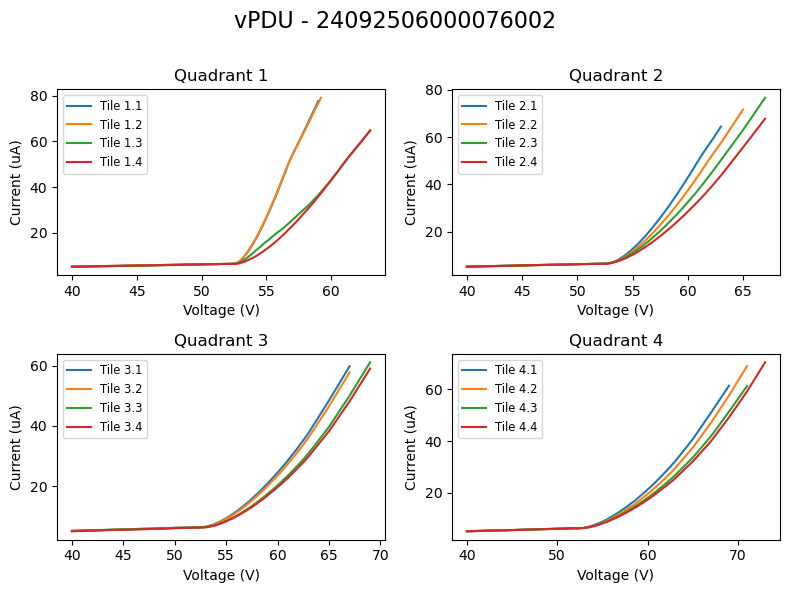

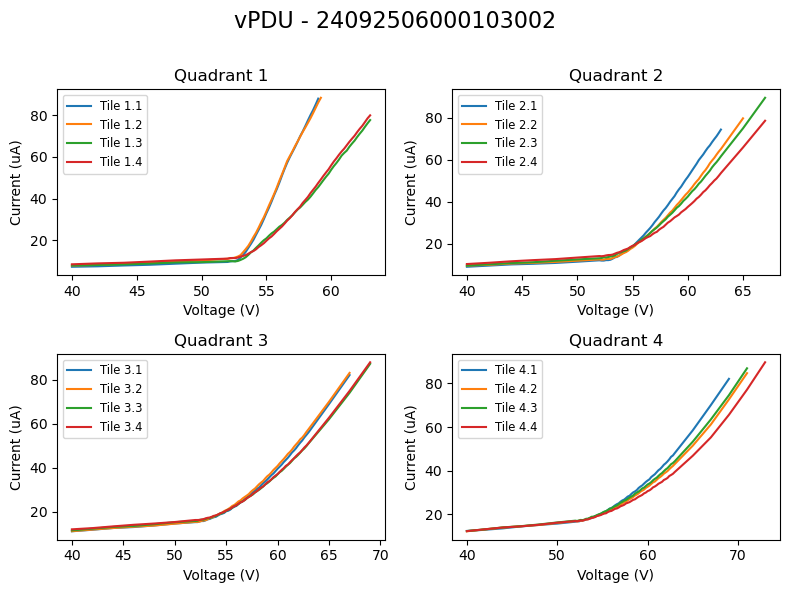

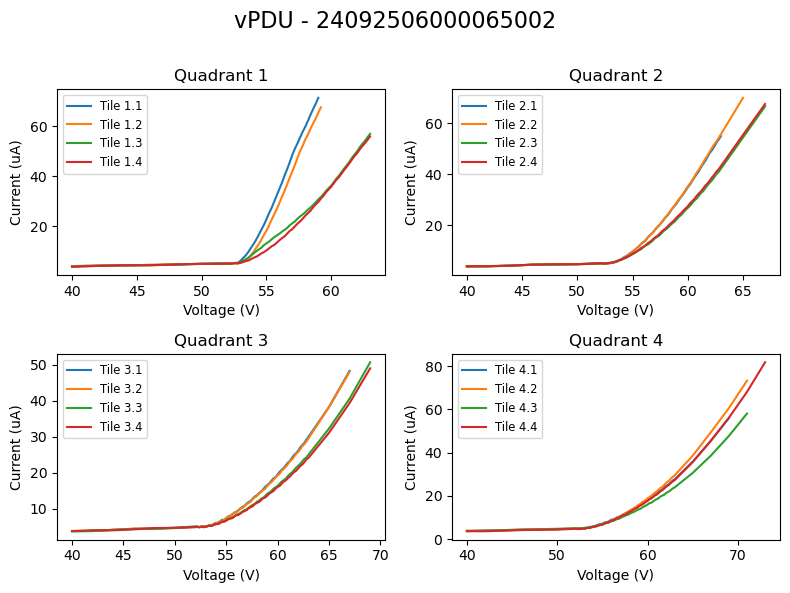

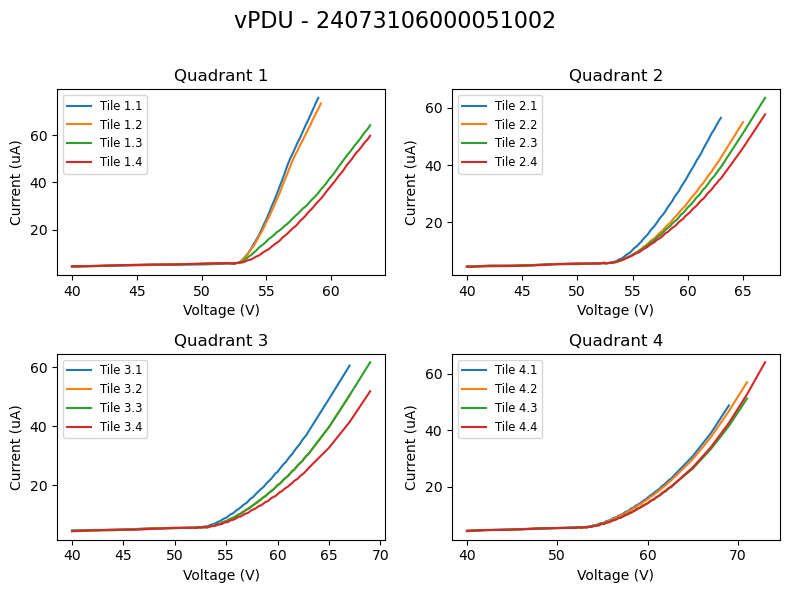

In [4]:
if configuration == 'tiles':
    
    if batch == 2 and layer == 'bottom': 
        for i in range(1,n_vpdus+1):
            plot_tiles(df, f'CAEN{i}_Voltage (V)', f'CAEN{i}_Current (uA)', f"vPDU - {vpdusQR[i]}", save = save, save_path= f'Batch_{batch}/{temperature}_tests/Plots/IV_{layer}/IV_{configuration}_{vpdusQR[i]}')
    else:
        for i in range(n_vpdus):
            plot_tiles(df, f'CAEN{i}_Voltage (V)', f'CAEN{i}_Current (uA)', f"vPDU - {vpdusQR[i+1]}", save = save, save_path= f'Batch_{batch}/{temperature}_tests/Plots/IV_{layer}/IV_{configuration}_{vpdusQR[i+1]}')
            
elif configuration == 'quadrants':
    
    if batch == 2 and layer == 'bottom': 
        for i in range(1,n_vpdus+1):
            plot_quadrant(df, f'CAEN{i}_Voltage (V)', f'CAEN{i}_Current (uA)', f"vPDU - {vpdusQR[i]}", save = save, save_path= f'Batch_{batch}/{temperature}_tests/Plots/IV_{layer}/IV_{configuration}_{vpdusQR[i]}')
    else:
        for i in range(n_vpdus):
            plot_quadrant(df, f'CAEN{i}_Voltage (V)', f'CAEN{i}_Current (uA)', f"vPDU - {vpdusQR[i+1]}", save = save, save_path= f'Batch_{batch}/{temperature}_tests/Plots/IV_{layer}/IV_{configuration}_{vpdusQR[i+1]}')

# Split Data

In [5]:
for file in os.listdir(f'Batch_{batch}/{temperature}_tests/Data/IV/splitted/'):
    if file.endswith(".txt"):
        os.remove(f'Batch_{batch}/{temperature}_tests/Data/IV/splitted/' + file)

if layer == 'top':
    s = split_v2(df, save = False, save_path = f'Batch_{batch}/{temperature}_tests/Data/IV/splitted/{layer}/{configuration}')
elif layer == 'bottom' and batch == 2:
    split_v2(df, save = False, save_path = f'Batch_{batch}/{temperature}_tests/Data/IV/splitted/{layer}/{configuration}')
else:
    split_v2(df, save = False, save_path = f'Batch_{batch}/{temperature}_tests/Data/IV/splitted/{layer}/{configuration}')

# Fit Data

In [6]:
### !!!!! FIX THIS CELL !!!!! 
def plot_group(file_indices, title, store, Vlim = [Vlow, Vhigh], save = False, save_path = None):
    
    IV = IVAnalysis.IVAnalysis()
    Vbd_Cold = [None] * 4
    Vbd_cold_err = [None] * 4

    plt.figure(figsize=[8, 6])
    for idx in file_indices:
        try:
            Vbd, Vbd_err = IV.calc_Vbd(file[idx], Vstart=Vlim[0], Vstop=Vlim[1], plot_opt=True)
            store.append(Vbd)
            IV.plot_tileIV(file[idx], label=f"Q{idx+1}, {Vbd:.2f} V")
            line = plt.gca().lines[-1]
            plt.axvline(Vbd, color=line.get_color(), linestyle=':', linewidth=3)
            print(f"✅ Q{idx+1}: Vbd = {Vbd:.2f} V ± {Vbd_err:.2f}")
        except Exception as e:
            print(f"❌ Fitting failed for ColdTileIV{idx+1}: {e}")
            store.append(np.nan)
            continue
    plt.xlabel("Voltage [V]")
    plt.ylabel("Current [uA]")
    plt.title(title)
    #plt.xlim(45, 64)
    plt.ylim(2.3, 140)
    #plt.legend()
    if save == True:
        plt.savefig(save_path)
    plt.show()
    #return store

if configuration == 'quadrants':
    file_path = f'Batch_{batch}/{temperature}_tests/Data/IV/splitted/{layer}/{configuration}'
    base_path = file_path
    
    file = [os.path.join(base_path, f"IV_q{i}.txt") for i in range(int(4 * n_vpdus))]
    
    plt.rcParams.update({'font.size': 18}) 
    plt.rcParams.update({'lines.linewidth': 3}) 
    plt.rcParams.update({'xtick.direction': 'in'}) 
    plt.rcParams.update({'ytick.direction': 'in'})
    
    # Plot files 0 to 3 in one figure
    Vbds = []
    for i in range(n_vpdus):
        plot_group(np.linspace(4*i, 4*i+3, 4, dtype = int), title=f"vPDU-{vpdusQR[i+1]}", store = Vbds, save = save, save_path = f'Batch_{batch}/{temperature}_tests/Plots/Vbds/Vbd_{vpdusQR[i+1]}')

 ## Breakdown Voltage

In [7]:
if configuration == 'quadrants':
    for i in range(n_vpdus):
        x = np.linspace(1, 4, 4)
        plt.figure()
        plt.title(f'{vpdusQR[i+1]}')
        plt.plot(x, Vbds[i*4:i*4+4], 'o')
        plt.ylabel('Bd Voltage (V)')
        plt.xlim([0.5,4.5])
        plt.ylim([min(Vbds) - min(Vbds)*0.05, max(Vbds) + max(Vbds)*0.05])

In [8]:
def svaeVbds(Vbds, filename="salida.txt"):
    if len(Vbds) % 4 != 0:
        raise ValueError("Values missing. Check if all the Vbds had been obtained.")

    arr = np.array(Vbds).reshape(-1, 4)
    np.savetxt(f'Batch_{batch}/{temperature}_tests/Data/IV/splitted/{layer}/{configuration}/' + filename, arr)

#svaeVbds(Vbds, filename = 'Vbds.txt' )

In [9]:
1.5 * 16

24.0